In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


Query date:  2016-08-23


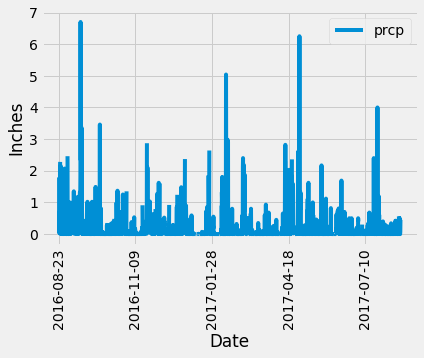

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(func.max(measurement.date)).all()
    
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print("Query date: ", query_date)

# Perform a query to retrieve the date and precipitation scores
date_prcp = session.query(measurement.date, measurement.prcp).filter(measurement.date >= query_date).all()
date_prcp

# Save the query results as a Pandas DataFrame and set the index to the date column
dateprcp_df = pd.DataFrame(date_prcp)
dateprcp_df.set_index(('date'), inplace=True)

# Sort the dataframe by date
dateprcp_df = dateprcp_df.sort_values("date")
dateprcp_df

# Use Pandas Plotting with Matplotlib to plot the data
dateprcp_df.plot(label="Annual Precipitation", rot='vertical')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
dateprcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.station)).all()


[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
filter(measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

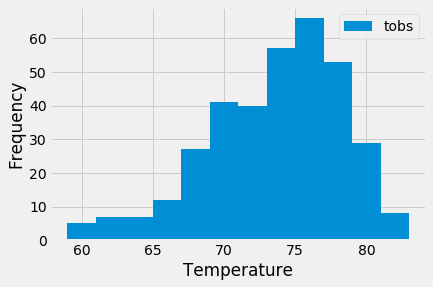

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel = [measurement.tobs]
tobs = session.query(*sel).filter(measurement.station == "USC00519281").filter(measurement.date >= query_date).all()

tobs_df = pd.DataFrame(tobs)

tobs_df['tobs'].plot(kind='hist', bins=12)

plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.show()


## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
start_date = input('Enter start date for trip using YYYY-MM-DD format: ')
end_date = input('Enter end date for trip ising YYYY-MM-DD format: ')

Enter start date for trip using YYYY-MM-DD format: 2016-10-15
Enter end date for trip ising YYYY-MM-DD format: 2016-10-18


In [21]:
prev_start = datetime.strptime(start_date, '%Y-%m-%d').date()
print(prev_start)

prev_end = datetime.strptime(end_date, '%Y-%m-%d').date()
print(prev_end)

2016-10-15
2016-10-18


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        prev_start = start_date - dt.timedelta(days=365)
        
    Returns:
        TMIN, TAVG, and TMAX
    """

    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

print(calc_temps(prev_start, prev_end))
query_results=(calc_temps(prev_start, prev_end))

[(70.0, 77.8, 81.0)]


Text(0.5, 1.0, 'Trip Avg Temp')

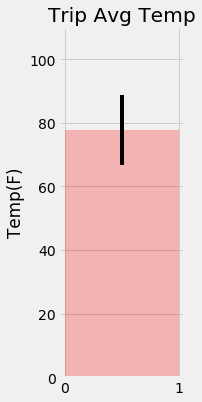

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = query_results[0][0]
tavg = query_results[0][1]
tmax = query_results[0][2]
peak = tmax-tmin

plt.figure(figsize=(2,6))
plt.ylim(0,110)
plt.bar(0.5, tavg, yerr=peak, align="center", width=1, color="red", alpha=0.25)
plt.ylabel("Temp(F)")
plt.title("Trip Avg Temp")

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.

rain = session.query(measurement.station, func.sum(measurement.prcp)).\
            filter(measurement.date >= prev_start).filter(measurement.date <= prev_end).\
            group_by(measurement.station).order_by(func.sum(measurement.prcp).desc()).all()

for item in rain:
    print(item[0], item[1])

    
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation.

sel = [measurement.station, func.sum(measurement.prcp), station.name, station.latitude, station.longitude, station.elevation]

rain_all = session.query(*sel).filter(measurement.station == station.station).\
            filter(measurement.date >= prev_start).filter(measurement.date <= prev_end).\
            group_by(measurement.station).order_by(func.sum(measurement.prcp).desc()).all()

for record in rain_all:
    print(record)

USC00516128 1.19
USC00519523 0.13999999999999999
USC00513117 0.08
USC00519281 0.07
USC00514830 0.05
USC00519397 0.01
USC00517948 None
('USC00516128', 1.19, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00519523', 0.13999999999999999, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00513117', 0.08, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519281', 0.07, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00514830', 0.05, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00519397', 0.01, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [101]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

normals = []

# Set the start and end date of the trip
prev_start
prev_end

# Use the start and end date to create a range of dates

date_range = session.query(measurement.date).\
            filter(measurement.date >= prev_start).\
            filter(measurement.date <= prev_end).\
            group_by(measurement.date).all()
date_range

# Strip off the year and save a list of %m-%d strings
trip_dates = [x[0] for x in date_range]

strip_year = [x[5:] for x in trip_dates]
strip_year

trip_start = strip_year[0]
trip_end = strip_year[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date

normals = [session.query(func.min(measurement.tobs),func.avg(measurement.tobs),func.max(measurement.tobs)).\
                filter(func.strftime("%m-%d", measurement.date) >= trip_start).\
                filter(func.strftime("%m-%d", measurement.date) <= trip_end).\
                group_by(func.strftime("%m-%d", measurement.date)).all()]

print('Daily Normals for 10-15 to 10-18')
normals = normals[0]
normals

Daily Normals for 10-15 to 10-18


[(67.0, 75.63461538461539, 82.0),
 (67.0, 75.59183673469387, 81.0),
 (65.0, 75.07843137254902, 83.0),
 (65.0, 75.0, 83.0)]

In [102]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normals, columns=['TMIN', 'TAVG', 'TMAX'])
normals_df

normals_df['Date'] = trip_dates
normals_df

normals_df.set_index('Date', inplace=True)
normals_df

,TMIN,TAVG,TMAX
Date,,,
2016-10-15,67.0,75.634615,82.0
2016-10-16,67.0,75.591837,81.0
2016-10-17,65.0,75.078431,83.0
2016-10-18,65.0,75.000000,83.0


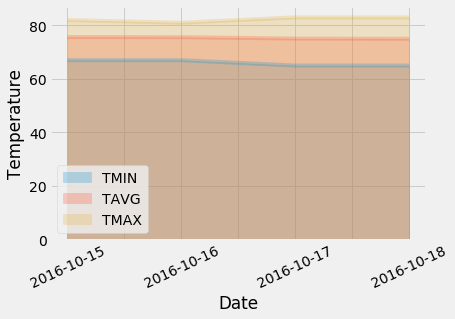

In [103]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', alpha=.25, stacked=False, rot=25)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend(loc='best')
plt.show()